In [ ]:
!nvidia-smi

Mon Sep  4 05:35:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import json
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/New folder

/content/drive/MyDrive/New folder


In [ ]:
df = pd.read_csv("final_details.csv")


In [ ]:
df=df.drop_duplicates(subset=['url'])
df = df[df.types != '[]']
df.describe()

,title,url,description,types
count,18397,18397,18396,18397
unique,17332,18397,14719,17254
top,Paella,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,30 mins,"['None', 'low-carb']"
freq,24,1,320,157


In [ ]:
df = df.dropna().reset_index(drop=True)
df.shape

(18396, 4)

In [ ]:
import ast

for i in range(len(df.types)):
  try:
    list_1 = ast.literal_eval(df.types[i])
    if isinstance(list_1, list):
      df.types[i] = list_1
  except (ValueError, SyntaxError):
    pass

In [ ]:
 types_list = df.types.to_list()

In [ ]:
mapping = {
    'Onion': 'Vegetable',
    'Poultry': 'Chicken',
    'saltwater\xa0Fish': 'saltwater fish',
    'Root Vegetable': 'Vegetable',
    'High-fiber Vegetarian Dish':'Vegetarian',
    'flowering vegetables':'Vegetable',
    'baked dish':'Baking',
    'leafy green vegetable':'Vegetable',
    'Gluten-free Dinner':'Gluten-free',
    'Gluten-free Vegetarian Recipe':'Gluten-free',
    'Gluten-free Lunch':'Gluten-free',
    'Vegetarian Entree': 'Vegetarian',
    'Vegetarian Lunch':'Vegetarian',
    'Vegetarian Dinner':'Vegetarian',
    'Side Salad':'salad',
    'dessert':'Dessert'
}

for sublist in types_list:
    for i in range(len(sublist)):
        sublist[i] = mapping.get(sublist[i], sublist[i])

types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Healthy Eating',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Pescetarian',
 'Special',
 '25-Minute',
 'Buffet',
 'Exotic',
 'Cooking on vacation',
 'festively',
 'Meal for Four',
 'Garden Party',
 'Guest',
 'Party',
 'Picnic',
 'Cooking',
 'Fish',
 'Vegetable',
 'Vegetable',
 'Vegetable',
 'Herb',
 'Dairy',
 'Fruit',
 'Brunch',
 'Snack',
 'Party Snack',
 'Party Snack',
 'Tapas',
 'Appetizer']

In [ ]:
for sublist in types_list:
    new_sublist = []
    for item in sublist:
        if item not in ['Family','skillet dish','Glyx','Classic', 'Spices','Meal for Four','Home Cooking', 'Side Dish','Grain','Primi Piatti','Main Course','Spring','Dinner','Lunch','Light Cooking','Herb','Casserole','Legume','Sauce','Clean Eating','Healthy Eating','Party Snack','Pescetarian','Picnic','Garden Party','Party','Stomach Discomfort','everyday meal','Elevated Blood Lipid','Crohn&#039;s Disease','European','Course','Main Course''Meal for Four','Menu', 'Guest', 'Easy', 'Lactation', 'Quick','Cooking','Osteoarthritis','Stress','Iron Deficiency','Cooking on vacation','Pregnancy','Fertility']:
            new_sublist.append(item)
    sublist[:] = new_sublist
types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Special',
 '25-Minute',
 'Buffet',
 'Exotic',
 'festively',
 'Fish',
 'Vegetable',
 'Vegetable',
 'Vegetable',
 'Dairy',
 'Fruit',
 'Brunch',
 'Snack',
 'Tapas',
 'Appetizer']

In [ ]:
for i in range (len(types_list)):
  types_list[i]=types_list[i][:10]

types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Special']

In [ ]:
for sublist in types_list:
    sublist[:] = list(set(sublist))
types_list[1]

['low-carb',
 '250-400 Calorie',
 'Low-calorie',
 'non-alcoholic',
 'Low-cholesterol',
 'Low-calorie Meat Dish',
 'Finger Food',
 'Special',
 'Fitness',
 'egg-free']

In [ ]:
df.types=types_list

In [ ]:
df

,title,url,description,types
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[low-carb, Vegetable, Cheese]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[low-carb, 250-400 Calorie, Low-calorie, non-alcoholic, Low-cholesterol, Low-calorie Meat Dish, Finger Food, Special, Fitness, egg-free]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[low-carb, nutritional, High-protein, non-alcoholic, Low-cholesterol, Mineral-rich, Gluten-free, Tofu, lactose-free, Gluten-free Vegan Recipe]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[low-carb, nutritional, Gluten-free Snack, vegetarian grilling, low-carb dinner, Gluten-free, 100-250 Calorie]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[low-carb, nutritional, Gluten-free Fish Recipe, Gluten-free Snack, Baking, pastry, North America, Gluten-free, regional, muffin]"
...,...,...,...,...
18391,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[250-400 Calorie, Quark-oil Dough, Dairy, Pork, Breakfast, Eggs, Milk]"
18392,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[skillet vegetables, What to Cook on Sunday?, Rustic, Baking, What to Cook on the Weekend?, North America, Family, Tunisian, Eggs, soul food]"
18393,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[non-alcoholic, Low-cholesterol, Vegetarian, Gluten-free, Low-fat, fat-free, Vegan, lactose-free, Low-sugar, Jelly]"
18394,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Bread Dough, Nut, Rustic, crowdpleaser, Country Style, Baking, Brunch, Yeast Dough, Bread, weekend cooking]"


In [ ]:
types_list = df.types.to_list()
type_count = {}
for type1 in types_list:
  if isinstance(type1, list):
    type_list = type1
  else:
    type_list = eval(type1)
  for type2 in type_list:
    if type2 in type_count.keys():
      type_count[type2] += 1
    else:
      type_count[type2] = 1
print(f"Number of types: {len(type_count)}")
print(type_count)

Number of types: 1028
{'low-carb': 5251, 'Vegetable': 6282, 'Cheese': 730, '250-400 Calorie': 722, 'Low-calorie': 243, 'non-alcoholic': 1204, 'Low-cholesterol': 828, 'Low-calorie Meat Dish': 4, 'Finger Food': 221, 'Special': 50, 'Fitness': 150, 'egg-free': 672, 'nutritional': 1003, 'High-protein': 1501, 'Mineral-rich': 524, 'Gluten-free': 931, 'Tofu': 95, 'lactose-free': 840, 'Gluten-free Vegan Recipe': 148, 'Gluten-free Snack': 115, 'vegetarian grilling': 27, 'low-carb dinner': 192, '100-250 Calorie': 411, 'Gluten-free Fish Recipe': 72, 'Baking': 2256, 'pastry': 510, 'North America': 475, 'regional': 267, 'muffin': 77, 'Snack': 661, 'Gluten-free Dessert': 96, 'Lactose-free Snacks': 62, 'high-fiber': 1145, 'High-fiber Snack': 90, 'Lactose-free Dessert': 42, 'Snack for Kids': 30, 'Vegan Dessert': 62, 'cooking for kids': 86, 'Children&#039;s Party': 29, 'Vegan Snack': 84, 'birthday for kids': 24, 'Vegan': 644, 'Skinny Diet': 43, 'High-fiber Fish Dish': 100, 'Stew': 291, 'High-fiber Soup'

In [ ]:
threshold = int(len(df) * 0.02)
rare_types = [key for key, value in type_count.items() if value < threshold]
len(rare_types), rare_types[:10]

(970,
 ['Low-calorie',
  'Low-calorie Meat Dish',
  'Finger Food',
  'Special',
  'Fitness',
  'Tofu',
  'Gluten-free Vegan Recipe',
  'Gluten-free Snack',
  'vegetarian grilling',
  'low-carb dinner'])

In [ ]:
types_list
revised_types_list = []
indices_to_drop = []

for idx, types in enumerate(types_list):
  if isinstance(types, list):
    type_list = types
  else:
    type_list = eval(types)

  revised_types = []

  for type1 in type_list:
    if type1 not in rare_types:
      revised_types.append(type1)

  if len(revised_types) == 0:
    indices_to_drop.append(idx)
  else:
    revised_types_list.append(revised_types)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(18302, 4)

In [ ]:
df['revised_types'] = revised_types_list

In [ ]:
df.tail()

,title,url,description,types,revised_types
18297,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[250-400 Calorie, Quark-oil Dough, Dairy, Pork, Breakfast, Eggs, Milk]","[250-400 Calorie, Dairy, Pork, Eggs]"
18298,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[skillet vegetables, What to Cook on Sunday?, Rustic, Baking, What to Cook on the Weekend?, North America, Family, Tunisian, Eggs, soul food]","[Baking, North America, Family, Eggs]"
18299,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[non-alcoholic, Low-cholesterol, Vegetarian, Gluten-free, Low-fat, fat-free, Vegan, lactose-free, Low-sugar, Jelly]","[non-alcoholic, Low-cholesterol, Vegetarian, Gluten-free, Low-fat, Vegan, lactose-free, Low-sugar]"
18300,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Bread Dough, Nut, Rustic, crowdpleaser, Country Style, Baking, Brunch, Yeast Dough, Bread, weekend cooking]",[Baking]
18301,Homemade Red Currant Jelly,https://eatsmarter.com/recipes/homemade-red-currant-jelly,"Bring the mixture to a boil, and cook for 4 minutes. Fill the jelly into the sterilized prepared jars. Seal tightly, and turn upside down for 15 minutes. Turn right side up and cool completely.","[marmalade, Summer, In a jar, Red Currant Jam, Fruit, Sweet, Pressure cooking, Red Currant Jelly, Jelly]",[Fruit]


In [ ]:
revised_types_list = df.revised_types.to_list()
revised_types_list

[['low-carb', 'Vegetable', 'Cheese'],
 ['low-carb',
  '250-400 Calorie',
  'non-alcoholic',
  'Low-cholesterol',
  'egg-free'],
 ['low-carb',
  'nutritional',
  'High-protein',
  'non-alcoholic',
  'Low-cholesterol',
  'Mineral-rich',
  'Gluten-free',
  'lactose-free'],
 ['low-carb', 'nutritional', 'Gluten-free', '100-250 Calorie'],
 ['low-carb',
  'nutritional',
  'Baking',
  'pastry',
  'North America',
  'Gluten-free'],
 ['nutritional', 'Snack', 'high-fiber', 'Gluten-free', 'lactose-free'],
 ['low-carb', 'nutritional', 'Vegan'],
 ['High-protein', 'high-fiber', 'diet'],
 ['low-carb', 'High-protein', 'non-alcoholic', 'Gluten-free', 'diet'],
 ['low-carb', 'Pasta', 'nutritional'],
 ['Low-cholesterol',
  'Mineral-rich',
  'non-alcoholic',
  'meat-free',
  'Gluten-free',
  'egg-free'],
 ['low-carb', 'Low-cholesterol', 'Fruit', 'Fish'],
 ['High-protein', 'high-fiber', 'Fish', 'diet'],
 ['nutritional',
  'high-fiber',
  'Vegetarian',
  'Gluten-free',
  'lactose-free',
  '100-250 Calorie'],


In [ ]:
revised_types_list
revised_type_count = {}
for types in revised_types_list:
  type_list = types
  for type1 in type_list:
    if type1 in revised_type_count.keys():
      revised_type_count[type1] += 1
    else:
      revised_type_count[type1] = 1
print(f"Number of types: {len(revised_type_count)}")
print(revised_type_count)

Number of types: 58
{'low-carb': 5251, 'Vegetable': 6282, 'Cheese': 730, '250-400 Calorie': 722, 'non-alcoholic': 1204, 'Low-cholesterol': 828, 'egg-free': 672, 'nutritional': 1003, 'High-protein': 1501, 'Mineral-rich': 524, 'Gluten-free': 931, 'lactose-free': 840, '100-250 Calorie': 411, 'Baking': 2256, 'pastry': 510, 'North America': 475, 'Snack': 661, 'high-fiber': 1145, 'Vegan': 644, 'diet': 1703, 'Pasta': 2673, 'meat-free': 582, 'Fruit': 1584, 'Fish': 1738, 'Vegetarian': 2071, 'Meat': 2172, 'Beef': 532, 'mushroom': 550, 'salad': 2924, 'Eggs': 819, 'Seafood': 741, 'soup': 753, 'German': 437, 'Dessert': 2005, 'Low-sugar': 389, 'Side Salad': 369, 'fruit-vegetable': 2325, 'saltwater fish': 1202, 'Vegetable Salad': 1061, 'Chicken': 1425, 'Asian': 1062, 'Appetizer': 453, 'Tropical Fruit': 786, 'Roast': 969, 'Shrimp': 595, 'Sprout': 786, 'Shellfish': 423, 'Family': 418, 'Low-fat': 561, 'Italian': 1048, 'Pork': 400, 'American': 418, 'Dairy': 471, 'Dough': 2481, 'dessert': 591, 'Rice': 172

In [ ]:
revised_type_count.keys()

dict_keys(['low-carb', 'Vegetable', 'Cheese', '250-400 Calorie', 'non-alcoholic', 'Low-cholesterol', 'egg-free', 'nutritional', 'High-protein', 'Mineral-rich', 'Gluten-free', 'lactose-free', '100-250 Calorie', 'Baking', 'pastry', 'North America', 'Snack', 'high-fiber', 'Vegan', 'diet', 'Pasta', 'meat-free', 'Fruit', 'Fish', 'Vegetarian', 'Meat', 'Beef', 'mushroom', 'salad', 'Eggs', 'Seafood', 'soup', 'German', 'Dessert', 'Low-sugar', 'Side Salad', 'fruit-vegetable', 'saltwater fish', 'Vegetable Salad', 'Chicken', 'Asian', 'Appetizer', 'Tropical Fruit', 'Roast', 'Shrimp', 'Sprout', 'Shellfish', 'Family', 'Low-fat', 'Italian', 'Pork', 'American', 'Dairy', 'Dough', 'dessert', 'Rice', 'Pome Fruit', 'Fruit Dessert'])

In [ ]:
encode_types = { key: idx for idx, (key, value) in enumerate(revised_type_count.items())}
with open("recipe_types_encoded.json", "w") as fp:
  json.dump(encode_types, fp)

In [ ]:
categorical_type_list = []
revised_types_list

for type5 in revised_types_list:
  categorical_list = [0] * len(encode_types)
  for type1 in type5:
    type1_index = encode_types[type1]
    categorical_list[type1_index] = 1
  categorical_type_list.append(categorical_list)

categorical_type_list[3][:45]

[0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
df['type_cat_list'] = categorical_type_list
df.head()

,title,url,description,types,revised_types,type_cat_list
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[low-carb, Vegetable, Cheese]","[low-carb, Vegetable, Cheese]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[Finger Food, Healthy Eating, Low-calorie, Low-cholesterol, Fitness]","[Healthy Eating, Low-cholesterol]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[nutritional, Tofu, Healthy Eating, Low-cholesterol, High-protein]","[nutritional, Healthy Eating, Low-cholesterol, High-protein]","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[nutritional, Gluten-free, Healthy Eating, vegetarian grilling, Clean Eating]","[nutritional, Gluten-free, Healthy Eating, Clean Eating]","[0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[nutritional, pastry, Gluten-free, muffin, Baking]","[nutritional, pastry, Gluten-free, Baking]","[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
labels = list(encode_types.keys())

In [ ]:
model_name = "distilbert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('type_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "/content/drive/MyDrive/New folder/dataloaders/dls-multilabel-recipe-classifier13.pkl")

In [ ]:
dls.vocab

['low-carb', 'Vegetable', 'Cheese', 'Healthy Eating', 'Low-cholesterol', 'nutritional', 'High-protein', 'Gluten-free', 'Clean Eating', 'pastry', 'Baking', 'high-fiber', 'diet', 'Fish', 'High-fiber Vegetarian Dish', 'Beef', 'salad', 'Eggs', 'Vegetarian', 'saltwater fish', 'fruit-vegetable', 'Vegetable Salad', 'flowering vegetables', 'Meat', 'Sauce', 'Asian', 'Chicken', 'Dessert', 'Herb', 'baked dish', 'Roast', 'Legume', 'Shrimp', 'Italian', 'soup', 'Seafood', 'non-alcoholic', 'Casserole', 'mushroom', 'Spices', 'leafy green vegetable', 'Sprout', 'Fruit', 'Tropical Fruit', 'Dough', 'Pome Fruit', 'Pasta', 'Rice', 'Fruit Dessert']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=10, trunc_at=256)

,text,target
0,"for the cornbread, mix the flours, baking powder, and salt in a bowl. add the milk, eggs, butter and sugar and mix with a hand mixer to make a smooth batter. pour into the baking dish and bake until golden brown about 45 minutes. if the bread starts to bec","[salad, Meat]"
1,"for the vegetables : scrub the potatoes and cook in a pan of boiling salted water until knife - tender, about 25 minutes, drain. rinse the vegetables and cut into bite - sized pieces. blanch the broccoli, broad beans and green beans in a pot of boiling sal","[Vegetable, Dough, Pasta]"
2,"rinse and par dry muscovy ducks inside and out, season with salt and pepper inside and out. rinse marjoram and stuff each duck with half of bunch. arrange ducks in a large roasting pan and roast in preheated oven at 220°c ( approximately 425°f ) for about","[Sauce, Chicken]"
3,rinse the herbs thoroughly. rinse the scallions and cut into strips. peel the carrots and cut in half or quarters. heat the remaining olive oil in a roasting pan. cook the meat. remove the meat from the roasting pan and place the herbs in it. return the me,"[low-carb, Roast]"
4,"peel onion and cut into fine strips. cut pomegranate in half and remove seeds. rinse apples, remove core, cut into quarters and then cut into thin sticks or coarsely grate. mix apples in a bowl with 1 - 2 tablespoons lemon juice. rinse thyme, shake dry and","[Vegetable, Vegetable Salad, Legume, Fruit]"
5,"melt 2 tablespoons butter in a saucepan, stir in flour, pour in milk while stirring, simmer for 10 minutes on low heat and season with salt and pepper. peel onion and chop finely. heat olive oil, saute onion until translucent, add spinach and season with s","[Vegetable, baked dish, Casserole]"
6,"rinse the zucchini, peel the carrots and grate coarsely both. halve the leek lengthwise, rinse, trim and thinly slice. melt 1 / 2 of the butter in a saucepan and saute the vegetables for 3 minutes. cook the noodles in boiling salted water for about 5 minut","[Vegetable, Casserole, Dough]"
7,"wipe mushrooms clean with a paper towel and cut into quarters. heat 2 tablespoons oil in a pan over medium heat. add mushrooms and saute, stirring, about 5 minutes. while cooking, season mushrooms with salt and pepper and add 1 tablespoon each lemon juice","[low-carb, Fish, saltwater fish, Vegetable Salad, mushroom]"
8,"cook the spaghetti in boiling salted water until al dente. rinse the eggplant, and remove the ends. slice, sprinkle with salt, and let stand for 10 minutes. rinse under cold water and drain well. rinse the zucchini, halve lengthwise, and thinly slice. scor","[Vegetable, Herb, Dough, Pasta]"
9,"for the filling : cut bacon into small cubes. peel and finely chop onions. rinse apples and rub dry. cut a lid off of each apple. with an apple corer, remove cores, leaving bottoms of apples intact. enlarge opening slightly and sprinkle with lemon juice. m","[Dessert, Fruit, Pome Fruit, Fruit Dessert]"


In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.5)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.019054606556892395, valley=0.0008317637839354575)

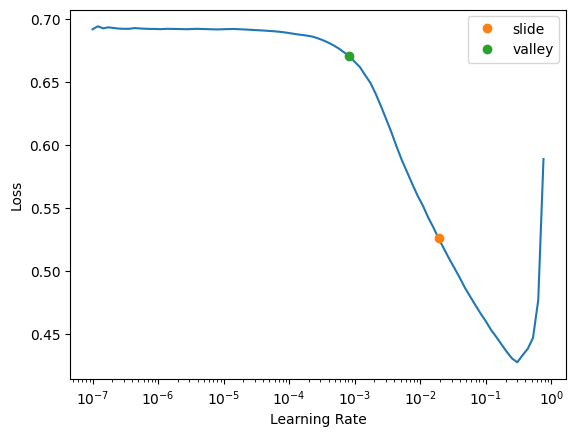

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.199910,0.189560,0.943471,00:32
1,0.183734,0.175132,0.943769,00:31
2,0.177864,0.170520,0.944891,00:30
3,0.172628,0.168602,0.945441,00:31
4,0.173087,0.168258,0.945384,00:40


In [ ]:
learner.save("recipe-classifier-stage-13")

Path('models/recipe-classifier-stage-13.pth')

In [ ]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-13.pkl")

SuggestedLRs(slide=0.0004786300996784121, valley=9.120108734350652e-05)

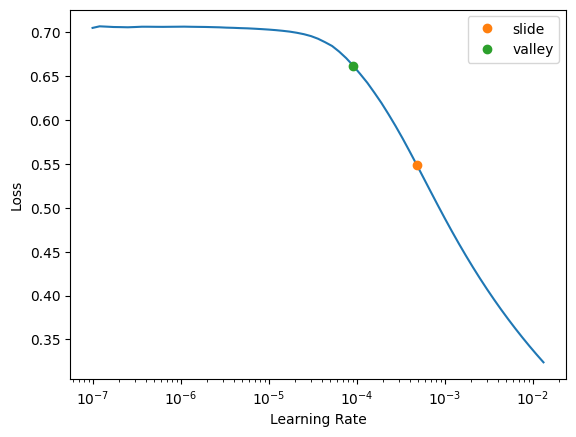

In [ ]:
learner.unfreeze()
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.000595,0.000285,1.000000,01:02
1,0.000075,0.000064,1.000000,01:08
2,0.000038,0.000035,1.000000,01:02
3,0.000029,0.000027,1.000000,01:03
4,0.000027,0.000026,1.000000,00:53


In [ ]:
learner.save("recipe-classifier-stage-9")

In [ ]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-9.pkl")